# Experiments results 

- Experiment 1: MACHO (PT) - Ogle (FT)
- Experiment 2: MACHO (PT) - Subsets of Ogle (FT) (20 - 50 - 100 observations per class)

In [1]:
cd /tf/astromer

/tf/astromer


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # comment to disable GPU
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from tensorboard.backend.event_processing import event_accumulator
from sklearn.metrics import confusion_matrix
from core.plots import plot_cm

def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['tensors']}
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = tf.make_ndarray(v.tensor)
            metrics[v.tag].append(value)
    return metrics

def load_weights(model, weights_path):
    model.load_weights(weights_path)
    model.trainable=False
    return model

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Experiment 1: Pretraning on MACHO - Finetuning on Ogle

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from presentation.experiments.exp_1 import get_mlp, get_lstm, get_lstm_att, init_astromer, valid_step
from sklearn.metrics import precision_recall_fscore_support
from core.data import load_records

In [6]:
astromer_weights = './weights/astromer_10022021/'
exp_folder = './experiments/alcock/'
data_exp = './data/records/alcock/'

In [7]:
encoder = init_astromer(astromer_weights)

In [8]:
test_batches = load_records(data_exp+'/test', batch_size=128, val_data=0, max_obs=200,
                            msk_frac=0., rnd_frac=0., same_frac=0., repeat=1) # repeat 1 == no repeat

No validation


In [9]:
test_obj_df = pd.read_csv(data_exp+'test_objs.csv')

classes_name = list(test_obj_df['class'].unique())
print(classes_name)
num_classes = len(classes_name)

['Cep_0', 'Cep_1', 'EC', 'LPV', 'RRab', 'RRc']


In [10]:
lstm     = get_lstm(256, num_classes, 200, dropout=0.5)
mlp_att  = get_mlp(num_classes, encoder)
lstm_att = get_lstm_att(256, num_classes, encoder=encoder, dropout=0.5)

In [11]:
lstm     = load_weights(lstm, exp_folder+'/lstm/weights')
mlp_att  = load_weights(mlp_att, exp_folder+'/mlp_att/weights')
lstm_att = load_weights(lstm_att, exp_folder+'/lstm_att/weights')

In [12]:
%%time
lstm_results     = {'name': 'LSTM', 'y_pred': [], 'y_true': [], 'cce': []}
mlp_att_results  = {'name': 'MLP+ATT', 'y_pred': [], 'y_true': [], 'cce': []}
lstm_att_results = {'name': 'LSTM+ATT', 'y_pred': [], 'y_true': [], 'cce': []}

for batch in test_batches:
    acc, ce, y_pred, y_true = valid_step(lstm, batch, return_pred=True)
    lstm_results['y_pred'].append(y_pred.numpy())
    lstm_results['y_true'].append(y_true.numpy())
    lstm_results['cce'].append(ce.numpy())
    
    acc, ce, y_pred, y_true = valid_step(mlp_att, batch, return_pred=True)
    mlp_att_results['y_pred'].append(y_pred.numpy())
    mlp_att_results['y_true'].append(y_true.numpy())
    mlp_att_results['cce'].append(ce.numpy())
    
    acc, ce, y_pred, y_true = valid_step(lstm_att, batch, return_pred=True)
    lstm_att_results['y_pred'].append(y_pred.numpy())
    lstm_att_results['y_true'].append(y_true.numpy())
    lstm_att_results['cce'].append(ce.numpy())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['lcid', 'length', 'label', 'output', 'mask_out', 'mean', 'obserr'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


CPU times: user 39.9 s, sys: 3.39 s, total: 43.3 s
Wall time: 12.8 s


In [13]:
def concat_batches_results(results):
    results['y_pred'] = np.concatenate(results['y_pred'], 0)
    results['y_true'] = np.concatenate(results['y_true'], 0)
    results['cce'] = np.mean(results['cce'], 0)
    return results

In [14]:
lstm_results     = concat_batches_results(lstm_results)
mlp_att_results  = concat_batches_results(mlp_att_results)
lstm_att_results = concat_batches_results(lstm_att_results)

In [15]:
print('{} & {} & {} & {} \\\\\hline'.format('Model', 'F1 Score', 'Recall', 'Precision'))
for result in [lstm_results, mlp_att_results, lstm_att_results]:
    if result['name'] == 'MLP+ATT':
        y_pred_lab = np.argmax(result['y_pred'], 1)
    else:
        y_pred_lab = np.argmax(result['y_pred'][:, -1, :], 1)
        
    prec, recall, f1, _ = precision_recall_fscore_support(result['y_true'], 
                                                          y_pred_lab, 
                                                          average='macro')
    
    print('{} & {:.2f} & {:.2f} & {:.2f} \\\\\hline'.format(result['name'], f1, recall, prec))

Model & F1 Score & Recall & Precision \\\hline
LSTM & 0.05 & 0.17 & 0.11 \\\hline
MLP+ATT & 0.15 & 0.28 & 0.11 \\\hline
LSTM+ATT & 0.74 & 0.74 & 0.78 \\\hline


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.0, 0.5, 'Categorical Cross Entropy')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


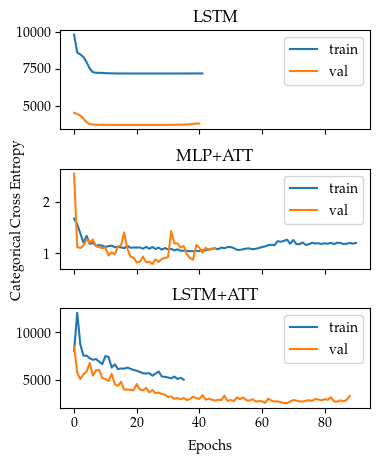

In [16]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(4,5), dpi=100, gridspec_kw={'hspace': 0.4, 'wspace': 0},)
for index, name in enumerate(['lstm', 'mlp_att', 'lstm_att']):
    train_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'train'))
    val_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'valid'))
    axes[index].plot(train_metrics['xentropy'], label='train')
    axes[index].plot(val_metrics['xentropy'], label='val')
    if name =='lstm': title_name = 'LSTM'
    if name =='mlp_att': title_name = 'MLP+ATT'
    if name =='lstm_att': title_name = 'LSTM+ATT'
    axes[index].set_title(title_name)
    axes[index].legend()
    
fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(0.0, 0.5, 'Categorical Cross Entropy', va='center', rotation='vertical')

Text(0.0, 0.5, 'Categorical Cross Entropy')

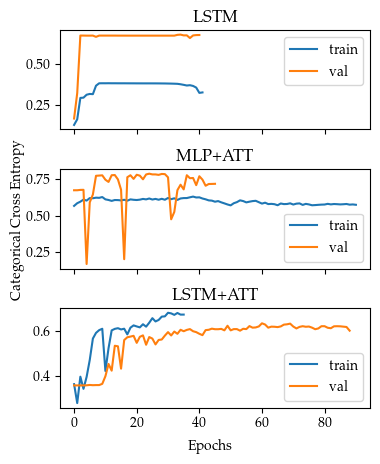

In [18]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(4,5), dpi=100, gridspec_kw={'hspace': 0.4, 'wspace': 0},)
for index, name in enumerate(['lstm', 'mlp_att', 'lstm_att']):
    train_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'train'))
    val_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'valid'))
    axes[index].plot(train_metrics['accuracy'], label='train')
    axes[index].plot(val_metrics['accuracy'], label='val')
    if name =='lstm': title_name = 'LSTM'
    if name =='mlp_att': title_name = 'MLP+ATT'
    if name =='lstm_att': title_name = 'LSTM+ATT'
    axes[index].set_title(title_name)
    axes[index].legend()
    
fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(0.0, 0.5, 'Categorical Cross Entropy', va='center', rotation='vertical')

In [83]:
lstm_cm     = confusion_matrix(lstm_results['y_true'], np.argmax(lstm_results['y_pred'][:, -1, :], 1), normalize='true')
mlp_att_cm  = confusion_matrix(mlp_att_results['y_true'], np.argmax(mlp_att_results['y_pred'], 1), normalize='true')
lstm_att_cm = confusion_matrix(lstm_att_results['y_true'], np.argmax(lstm_att_results['y_pred'][:, -1, :], 1), normalize='true')

In [84]:
for classes_name

SyntaxError: invalid syntax (<ipython-input-84-fc733b4cbc8e>, line 1)

In [29]:
fig, axes = plt.subplots(1,3, figsize=(27,8), sharey=True, gridspec_kw={'hspace': 0., 'wspace': 0.03})

axes[0] = plot_cm(lstm_cm, axes[0], title='LSTM', class_names=classes_name)
axes[1] = plot_cm(mlp_att_cm, axes[1], title='MLP + ATT', class_names=classes_name)
axes[2] = plot_cm(lstm_att_cm, axes[2], title='LSTM + ATT', class_names=classes_name)

RuntimeError: latex was not able to process the following string:
b'Cep_0'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/root/.cache/matplotlib/tex.cache/ff21415dfc29d4b16f72ca1d8e1d3d7f.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/mathpazo.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(./ff21415dfc29d4b16f72ca1d8e1d3d7f.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1ppl.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily Cep_
                    0}
No pages of output.
Transcript written on ff21415dfc29d4b16f72ca1d8e1d3d7f.log.




RuntimeError: latex was not able to process the following string:
b'Cep_0'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/root/.cache/matplotlib/tex.cache/ff21415dfc29d4b16f72ca1d8e1d3d7f.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/mathpazo.sty)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/share/texlive/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.dfu)))
(./ff21415dfc29d4b16f72ca1d8e1d3d7f.aux)
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/ot1ppl.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily Cep_
                    0}
No pages of output.
Transcript written on ff21415dfc29d4b16f72ca1d8e1d3d7f.log.




<Figure size 1944x576 with 3 Axes>